In [94]:
from pathlib import Path

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from src.model.ITrackerModel import ITrackerModel
from torchvision import transforms

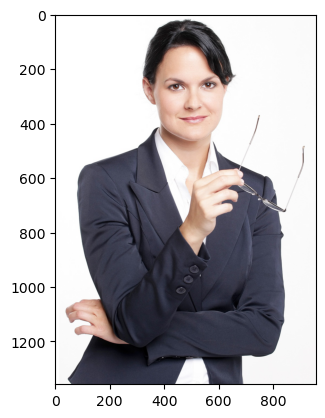

In [2]:
import cv2

img = cv2.imread("..\\data\\raw\\Images\\image.png")[:,:,[2,1,0]]
plt.imshow(img)

In [13]:
# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='..\\data\\pytorch_checkpoints\\face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("..\\data\\raw\\Images\\image.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

In [14]:
import math
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int):
  """Converts normalized value pair to pixel coordinates."""
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

In [15]:
image = image.numpy_view()

In [47]:
import numpy
def item_crop(image, detection_result, landmark_indeces):
    landmarks = [detection_result.face_landmarks[0][i] for i in landmark_indeces]
    xy = [_normalized_to_pixel_coordinates(x.x, x.y, image.shape[1], image.shape[0]) for x in landmarks]
    minx = min([x[0] for x in xy])
    miny = min([x[1] for x in xy])
    maxx = max([x[0] for x in xy])
    maxy = max([x[1] for x in xy])
    return image[miny:maxy, minx: maxx]

def item_mask(image, detection_result, landmark_indeces):
    landmarks = [detection_result.face_landmarks[0][i] for i in landmark_indeces]
    xy = [_normalized_to_pixel_coordinates(x.x, x.y, image.shape[1], image.shape[0]) for x in landmarks]
    minx = min([x[0] for x in xy])
    miny = min([x[1] for x in xy])
    maxx = max([x[0] for x in xy])
    maxy = max([x[1] for x in xy])
    row_mask = numpy.ma.getmask(numpy.ma.masked_inside(range(image.shape[1]), minx, maxx))
    column_mask = numpy.ma.getmask(numpy.ma.masked_inside(range(image.shape[0]), miny, maxy))
    return numpy.outer(column_mask, row_mask)

In [48]:
# Where these numbers came from https://storage.googleapis.com/mediapipe-assets/documentation/mediapipe_face_landmark_fullsize.png
left_eye_landmark_indeces = [343, 283]
right_eye_landmark_indeces = [53, 114]
face_landmark_indeces = {item for sublist in mp.solutions.face_mesh.FACEMESH_FACE_OVAL for item in sublist}
left_eye_crop = item_crop(image, detection_result, left_eye_landmark_indeces)
right_eye_crop = item_crop(image, detection_result, right_eye_landmark_indeces)
face_crop = item_crop(image, detection_result, face_landmark_indeces)
face_mask = item_mask(image, detection_result, face_landmark_indeces)

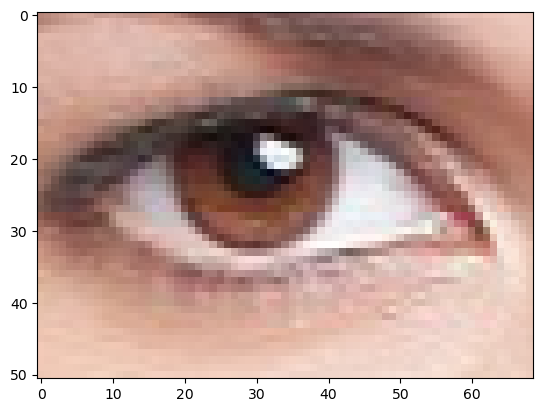

In [49]:
plt.imshow(right_eye_crop)

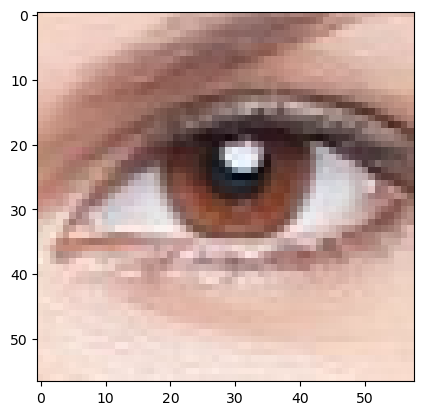

In [50]:
plt.imshow(left_eye_crop)

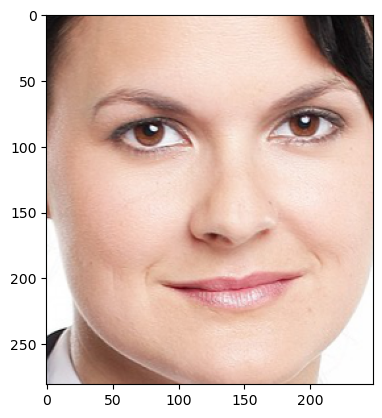

In [51]:
plt.imshow(face_crop)

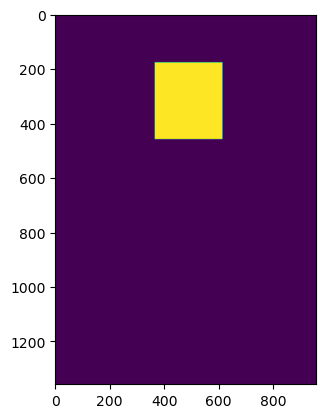

In [52]:
plt.imshow(face_mask)

# Model Inference

In [61]:
from src.model.ITrackerModel import ITrackerModel
import torch

device = torch.device("cuda:0")
model = ITrackerModel().to(device)

In [62]:
left_eye_crop = item_crop(image, detection_result, left_eye_landmark_indeces)
right_eye_crop = item_crop(image, detection_result, right_eye_landmark_indeces)
face_crop = item_crop(image, detection_result, face_landmark_indeces)
face_mask = item_mask(image, detection_result, face_landmark_indeces)

In [134]:
imSize = 224

with open('normalize_mean.npy', 'rb') as f:
    mean = np.load(f)
def static_normalize(data):
    shape = data.shape
    data = np.reshape(data, (-1))
    data = data / 255. # scaling
    data = data - mean # normalizing
    return np.reshape(data, shape)

def prepare_data(face, eye_left, eye_right, face_mask):
    # resize inputs to be 64 x 64 images, consistent with training data
    face, eye_left, eye_right, face_mask = \
        cv2.resize(face, (64, 64), cv2.INTER_NEAREST), \
        cv2.resize(eye_left, (64, 64), cv2.INTER_NEAREST), \
        cv2.resize(eye_right, (64, 64), cv2.INTER_NEAREST), \
        cv2.resize(np.float32(face_mask), (25, 25), cv2.INTER_NEAREST), \
            
    eye_left = static_normalize(eye_left)
    eye_right = static_normalize(eye_right)
    face = static_normalize(face)
    face_mask = np.reshape(face_mask, (face_mask.shape[0], -1)).astype('float32')
    # Make into torch tensors
    face, eye_left, eye_right, face_mask = \
        torch.FloatTensor(face),\
        torch.FloatTensor(eye_left),\
        torch.FloatTensor(eye_right),\
        torch.FloatTensor(face_mask)

    # Permute images
    face, eye_left, eye_right = \
    face.permute(2,0,1),\
        eye_left.permute(2,0,1),\
        eye_right.permute(2,0,1)

    # Resize images
    resize = transforms.Resize(imSize)
    face, eye_left, eye_right = \
        resize(face),\
        resize(eye_left),\
        resize(eye_right)
    
    # To device
    face, eye_left, eye_right, face_mask = face.to(device), eye_left.to(device), eye_right.to(device), face_mask.to(device)
    
    #add batch dimension to make it compatible with model
    face, eye_left, eye_right, face_mask = face.unsqueeze(0), eye_left.unsqueeze(0), eye_right.unsqueeze(0), face_mask.unsqueeze(0)
    return face, eye_left, eye_right, face_mask

In [104]:
face, eyes_left, eyes_right, mask = prepare_data(face_crop, left_eye_crop, right_eye_crop, face_mask)

<class 'numpy.ndarray'>


In [105]:
face.shape

torch.Size([1, 3, 224, 224])

In [106]:
eyes_left.shape

torch.Size([1, 3, 224, 224])

In [107]:
eyes_right.shape

torch.Size([1, 3, 224, 224])

In [108]:
mask.shape

torch.Size([1, 25, 25])

In [109]:
model.eval()
outputs = model(face, eyes_left, eyes_right, mask)

# End 2 End

In [124]:
# Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='..\\data\\pytorch_checkpoints\\face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# Relevent landmark indeces
left_eye_landmark_indeces = [343, 283]
right_eye_landmark_indeces = [53, 114]
face_landmark_indeces = {item for sublist in mp.solutions.face_mesh.FACEMESH_FACE_OVAL for item in sublist}

# Load pytorch model
device = torch.device("cuda:0")
model = ITrackerModel()
model.load_state_dict(torch.load('best_gazecapture_model.pth'))
model = model.to(device)
model.eval()

def gaze_prediction(image):
    frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    detection_result = detector.detect(frame)
    frame = frame.numpy_view()
    
    left_eye_crop = item_crop(frame, detection_result, left_eye_landmark_indeces)
    right_eye_crop = item_crop(frame, detection_result, right_eye_landmark_indeces)
    face_crop = item_crop(frame, detection_result, face_landmark_indeces)
    face_mask = item_mask(frame, detection_result, face_landmark_indeces)
    face, eyes_left, eyes_right, mask = prepare_data(face_crop, left_eye_crop, right_eye_crop, face_mask)
    return model(face, eyes_left, eyes_right, mask)

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

LINE_UP = '\033[1A'
LINE_CLEAR = '\x1b[2K'

# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()
        prediction = gaze_prediction(frame).detach().cpu().numpy().tolist()
        print(prediction[0])
        print(LINE_UP, end=LINE_CLEAR)
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

None

[0.9493498802185059, 2.4527206420898438]
[-0.4395824372768402, 2.106091260910034]
[4.316425800323486, 1.6091432571411133]
[4.133045673370361, 2.1809592247009277]
[2.980350971221924, 3.006742238998413]
[2.603476047515869, 2.8216652870178223]
[2.635349750518799, 2.526279926300049]
[4.056366443634033, 2.48872447013855]
[4.408679962158203, 5.047300338745117]
[4.16803503036499, 5.583211898803711]
[4.520824432373047, 5.315501689910889]
[5.690218925476074, 5.803656101226807]
[5.887374401092529, 5.631377220153809]
[6.936769485473633, 5.57374906539917]
[5.21306848526001, 5.8003010749816895]
[-0.23651283979415894, 3.4934134483337402]
[-3.4950454235076904, 5.503263473510742]
[-4.005884170532227, 3.2496604919433594]
[5.7535223960876465, 4.667963981628418]
[6.048119068145752, 4.879485130310059]
[7.215480327606201, 5.471956253051758]
[7.487467288970947, 5.83174467086792]
[6.859059810638428, 5.525866508483887]
[-3.4179182052612305, 2.43562388420105]
[2.1531176567077637, 1.468451738357544]
[4.13508272

Exception in thread Thread-28 (view):
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\GazeMouse\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\ProgramData\Anaconda3\envs\GazeMouse\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Jacob Lopez\AppData\Local\Temp\ipykernel_19656\329724740.py", line 31, in view
  File "C:\Users\Jacob Lopez\AppData\Local\Temp\ipykernel_19656\148891360.py", line 23, in gaze_prediction
TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. mediapipe.python._framework_bindings.image.Image(image_format: mediapipe::ImageFormat_Format, data: numpy.ndarray[numpy.uint8])
    2. mediapipe.python._framework_bindings.image.Image(image_format: mediapipe::ImageFormat_Format, data: numpy.ndarray[numpy.uint16])
    3. mediapipe.python._framework_bindings.image.Image(image_format: mediapipe::ImageFormat_Format, data: 

# End 2 End part 2

In [1]:
from src.model.EyeTracker import EyeTracker
import mediapipe as mp

In [2]:
itracker_checkpoint = 'best_gazecapture_model.pth'
torch_device = 'cuda:0'
normalizer_file = 'normalize_mean.npy'
detector_checkpoint = '..\\data\\pytorch_checkpoints\\face_landmarker_v2_with_blendshapes.task'

In [3]:
tracker = EyeTracker(itracker_checkpoint, torch_device, normalizer_file, detector_checkpoint)

In [4]:
img = mp.Image.create_from_file("..\\data\\raw\\Images\\image.png").numpy_view()
tracker.e2e_gaze_prediction(img)

c:\ProgramData\Anaconda3\envs\GazeMouse\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[5.6264, 7.7820]], device='cuda:0', grad_fn=<AddmmBackward0>)

# End 2 End part 3

In [9]:
from src.model.EyeTracker import EyeTracker
from src.model.EyeTracker import item_crop
from src.model.EyeTracker import item_mask
from src.model.EyeTracker import prepare_detector
import mediapipe as mp

In [10]:
itracker_checkpoint = 'best_gazecapture_model.pth'
torch_device = 'cuda:0'
normalizer_file = 'normalize_mean.npy'
detector_checkpoint = '..\\data\\pytorch_checkpoints\\face_landmarker_v2_with_blendshapes.task'

In [11]:
img = mp.Image.create_from_file("..\\data\\raw\\Images\\image.png").numpy_view()
detector = prepare_detector('..\\data\\pytorch_checkpoints\\face_landmarker_v2_with_blendshapes.task')
tracker = EyeTracker(itracker_checkpoint, torch_device, normalizer_file, detector_checkpoint)

In [12]:
frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
detection_result = detector.detect(frame)
frame = frame.numpy_view()

left_eye_crop = item_crop(frame, detection_result, EyeTracker.left_eye_landmark_indeces)
right_eye_crop = item_crop(frame, detection_result, EyeTracker.right_eye_landmark_indeces)
face_crop = item_crop(frame, detection_result, EyeTracker.face_landmark_indeces)
face_mask = item_mask(frame, detection_result, EyeTracker.face_landmark_indeces)

In [13]:
tracker.gaze_prediction(face_crop, left_eye_crop, right_eye_crop, face_mask)

c:\ProgramData\Anaconda3\envs\GazeMouse\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[5.6264, 7.7820]], device='cuda:0', grad_fn=<AddmmBackward0>)